## 章節 5：發生比與分佈相加（Odds and Addends）

### 5.5 最大值（Maxima）

當你產生一個 Dungeons & Dragons 角色，通常尤其在意角色最好的屬性，所以你會想知到最大值屬性的分佈。

有三種方式計算最大值的分佈：
1. 模擬法（Simulation）：給定一個 Pmf 代表單次選擇的分佈，你可以隨機取樣後找出最大值，產生模擬最大值的分佈。
2. 列舉法（Enumeration）：給定兩個 Pmf 分佈，你可以列舉所有兩兩配對的最大值結果來產生加總的分佈。
3. 冪次法（Exponentiation）： 如果我們將 Pmf 轉換成 Cdf，則有個簡單又有效率的演算法找到 Cdf 的最大值。

### 模擬法（Simulation）

SampleMax 方法幾乎跟 SampleSum 方法一樣，只差在將加總（sum）替換成（max）。

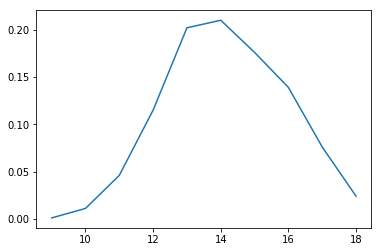

In [24]:
from thinkbayes import Pmf, MakePmfFromList
import matplotlib.pyplot as plt

def SampleMax(dists, n):
    pmf = MakePmfFromList(RandomMax(dists) for i in range(n)) # RandomSum 換成 RandomMax
    return pmf


def RandomMax(dists):
    total = max(dist.Random() for dist in dists) # sum 換成 max
    return total


def plot_suite(suite):
    x, y = zip(*sorted(suite.Items()))
    plt.plot(x, y)


class Die(Pmf): # 定義一個骰子的類別
    def __init__(self, sides):
        super().__init__()
        for num in range(1, sides+1):
            self.Set(num, 1) # 均勻分佈
            
        self.Normalize()
        

d6 = Die(6) # 產生一個六面骰子
three_exact = d6+d6+d6

six_attribute = [three_exact]*6 # 依據遊戲規則，有六個屬性需要決定數值，每個屬性數值為擲骰子三次加總
sample_size = 1000
# SampleSum 方法將一序列的 Pmf 或是 Cdf 物件做 sample_size 次數的隨機取樣後加總，產生另一個 Pmf 物件。
six_max = SampleMax(six_attribute, sample_size) 
plot_suite(six_max)

### 列舉法（Enumeration）

列舉法程式碼也幾乎相同。

並且注意下圖中模擬法可能會因為某些結果的機率較底而沒有產生出數值，例如最大值為 9 以下的情況。

模擬法的問題就在效率，若每個 Pmf 有 m 個數值，要做 k 次的選擇，則執行時間跟 $k*m^{2}$ 成正比。

PmfMax 分佈隨選取次數的變化


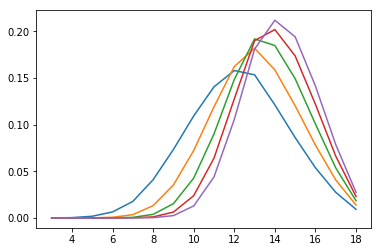

模擬法與列舉法的分佈


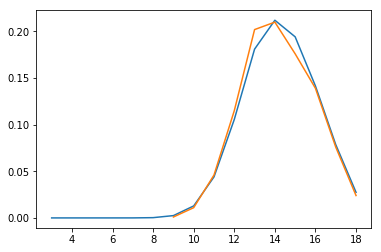

In [40]:
from functools import reduce

# 事實上你可以用一個適當的運算子最為參數來抽象化此方法。
def PmfMax(pmf1, pmf2):
    res = Pmf()
    for v1, p1 in pmf1.Items():
        for v2, p2 in pmf2.Items():
            res.Incr(max(v1, v2), p1*p2) # 將 v1, v2 取最大值
    plot_suite(res)
    return res

six_max_exact = reduce(PmfMax, six_attribute) 
print("PmfMax 分佈隨選取次數的變化")
plt.show() # 變化情形

print("模擬法與列舉法的分佈")
plot_suite(six_max_exact) # 橘色線條為列舉法
plot_suite(six_max) # 藍色線條為模擬法

### 冪次法（Exponentiation）

如果我們將 Pmf 轉成 Cdf，可以計算的更有效率！關鍵在於 Cdf 的定義：

$$CDF(x) = p(X \leq x)$$

X 是一個隨機變數，意義是「從此分佈隨機抽出的數值」。例如 CDF(5) 代表從分佈裡抽出數值小於等於 5 的機率。

如果我從 CDF1 抽出 X 與 CDF2抽出 Y，並且計算最大值 Z = max(X, Y)，請問 Z 小於等於 5 的機率是多少？在這種情況下 X 和 Y 都要小於等於 5。

如果 X 和 Y 的取樣是獨立的，則：

$$ CDF_{3}(5) = CDF_{1}(5)*CDF_{2}(5) $$

CDF3 就是 Z 的分佈。

上方的例子用 5 是為了方便思考，但我們可以普遍化到對所有的數值 z：

$$ CDF_{3}(z) = CDF_{1}(z)*CDF_{2}(z) $$

若我們對於相同的分佈抽取 k 個數值，變成為一種特例形式：

$$ CDF_{k}(z) = CDF_{1}(z)^k $$

所以產生抽取 k 次後最大數值的分佈，我們可以列舉 CDF 中所有的數值，並且計算 k 次方。

thinkbayes.py 中的 Cdf 類別提供一個 Max 方法：

<pre>
# class Cdf
def Max(self, k):
    cdf = self.Copy()
    cdf.ps = [p**k for p in cdf.ps] # 對 cdf 某一數值對應的機率做 k 次方
    return cdf
</pre>

此方法的執行時間跟 CDF 的數值數量 m 成正比。Pmf.Max 方法做同樣的事情，只不過需要將 Pmf 物件轉換成 Cdf 物件。

下方為冪次法的執行結果，會發現冪次法與列舉法的結果重合。

創建的角色中，其有一屬性出現 18 點的機率約為 3%。

六個屬性中出現 18 點的機率為： 0.027458253422613543


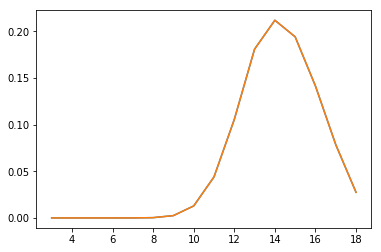

In [41]:
best_attr_cdf = three_exact.Max(6)
six_max_exp = best_attr_cdf.MakePmf()
plot_suite(six_max_exp)
plot_suite(six_max_exact)
print("六個屬性中出現 18 點的機率為：", six_max_exp.Prob(18))